In [315]:
import numpy as np

In [316]:
data = np.load('Intial_clip_test.npy')
labels = np.load("Labels.npy")
data
data.shape, labels.shape

((12008, 227, 67), (12008,))

In [317]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [318]:
labels

array(['L', 'R', 'L', ..., 'R', 'L', 'L'], dtype='<U8')

In [319]:
from sklearn.model_selection import train_test_split

In [320]:
# X_train, X_test, y_train, y_test = train_test_split(data, y_encoded_repeated, test_size= .3, random_state = 42)

In [321]:
y_encoded

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [322]:
X_train = np.load("TrainTestData/X_train.npy")
y_train = np.load("TrainTestData/y_train.npy")
X_val = np.load("TrainTestData/X_val.npy")
y_val = np.load("TrainTestData/y_val.npy")
X_test = np.load("TrainTestData/X_test.npy")
y_test = np.load("TrainTestData/y_test.npy")

In [323]:
X_train.shape, X_val.shape, X_test.shape,  y_train.shape, y_val.shape, y_test.shape

((5411, 227, 67), (1415, 227, 67), (31, 227, 67), (5411,), (1415,), (31,))

In [324]:
y_train.shape

(5411,)

In [325]:
y_test_encoded

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [326]:
from sklearn.preprocessing import StandardScaler

clips, frames, landmarks = X_train.shape
# Reshape to 2D for scaling: (clips * frames, landmark features)
X_train_reshaped = X_train.reshape(-1, landmarks)

# Fit and scale using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# Reshape back to original 3D shape
X_train_scaled = X_train_scaled.reshape(clips, frames, landmarks)

X_val_reshaped = X_val.reshape(-1, landmarks)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

# Scale test data using the same scaler
X_test_reshaped = X_test.reshape(-1, landmarks)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [329]:
X_train_scaled.shape, y_train.shape

((5411, 227, 67), (5411,))

In [335]:
n_samples, n_timesteps, n_features = X_train_scaled.shape


In [342]:
X_train_scaled[0].shape

(227, 67)

In [341]:
X_train_scaled.reshape(n_samples, n_timesteps*n_features)[0].shape

(15209,)

In [343]:
from imblearn.over_sampling import SMOTE
from collections import Counter
n_samples, n_timesteps, n_features = X_train_scaled.shape
X_flat = X_train_scaled.reshape(n_samples, n_timesteps * n_features)

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y_train)

# Step 3: Reshape the data back to original format
X_resampled = X_resampled_flat.reshape(-1, n_timesteps, n_features)

# Check new class distribution
print("Resampled class distribution:", Counter(y_resampled))

# Optional: Verify shapes
print(f"Original X shape: {X_train.shape}, Resampled X shape: {X_resampled.shape}")
print(f"Original y shape: {y_train.shape}, Resampled y shape: {y_resampled.shape}")

Resampled class distribution: Counter({'R': 2359, 'L': 2359, 'C': 2359})
Original X shape: (5411, 227, 67), Resampled X shape: (7077, 227, 67)
Original y shape: (5411,), Resampled y shape: (7077,)


In [345]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_resampled)

y_train_encoded = to_categorical(encoded_labels, num_classes=3)
y__train_encoded_repeated = np.repeat(y_train_encoded[:, np.newaxis, :], 227, axis=1)  # Shape (samples, 219, 3)
y_val_encoded = to_categorical(label_encoder.fit_transform(y_val), num_classes=3)
y__val_encoded_repeated = np.repeat(y_val_encoded[:, np.newaxis, :], 227, axis=1)
y_test_encoded = to_categorical(label_encoder.fit_transform(y_test), num_classes=3)
y__test_encoded_repeated = np.repeat(y_test_encoded[:, np.newaxis, :], 227, axis=1)


In [ ]:
X_train_scaled.shape, y__train_encoded_repeated.shape, X_train.shape

((5411, 227, 67), (5411, 227, 3), (5411, 227, 67))

In [355]:
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
model = Sequential()

# Add LSTM layer
model.add(LSTM(units = 128, input_shape=(X_resampled.shape[1], X_resampled.shape[2]), activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True))

# Dropout to avoid overfitting
model.add(Dropout(0.8))
model.add(BatchNormalization())
# Add another LSTM layer (optional)
model.add(LSTM(64, activation='tanh', kernel_regularizer=l2(0.01) ,return_sequences=True))
model.add(Dropout(0.8))
model.add(BatchNormalization())
# model.add(LSTM(32, activation='tanh', kernel_regularizer=l2(0.01) ,return_sequences=True))
# model.add(Dropout(0.8))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())

# Add Dense layer for classification at each time step
model.add(Dense(3, activation='softmax'))

# Compile the model
# loss_fn = SigmoidFocalCrossEntropy()
# model.compile(optimizer= tf.keras.optimizers.Adam(clipvalue = 1.0), loss=loss_fn, metrics=['accuracy'])
#clipvalue = 1.0
model.compile(optimizer= tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath="models/model_epoch_{epoch:02d}.keras", 
                              monitor='val_loss',  # Metric to monitor
                              save_best_only=False,  # Save only the best weights
                              verbose=1)

# Summary of the model
model.summary()

# Fit the model
history = model.fit(X_resampled, y__train_encoded_repeated, epochs=20,callbacks=[checkpoint], validation_data = (X_val_scaled, y__val_encoded_repeated), batch_size=64)

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_103 (LSTM)                 │ (None, 227, 128)       │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 227, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 227, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_104 (LSTM)                 │ (None, 227, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 227, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 227, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 227, 3)         │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,723 (588.76 KB)

 Trainable params: 150,339 (587.26 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.3934 - loss: 3.2553
Epoch 1: saving model to models/model_epoch_01.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 401ms/step - accuracy: 0.3937 - loss: 3.2482 - val_accuracy: 0.4018 - val_loss: 1.5575
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5356 - loss: 1.3107
Epoch 2: saving model to models/model_epoch_02.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 404ms/step - accuracy: 0.5356 - loss: 1.3101 - val_accuracy: 0.3900 - val_loss: 1.3807
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5771 - loss: 1.0826
Epoch 3: saving model to models/model_epoch_03.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 44s 399ms/step - accuracy: 0.5772 - loss: 1.0824 - val_accuracy: 0.3642 - val_loss: 1.3764
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6037 - loss: 1.0087
Epoch 4: saving model to models/model_epoch_04.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 401ms/step - accuracy: 0.6038 - loss: 1.008

In [357]:
model.fit(X_resampled, y__train_encoded_repeated, epochs=20,callbacks=[checkpoint], validation_data = (X_val_scaled, y__val_encoded_repeated), batch_size=64)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5108 - loss: 1.2190
Epoch 1: saving model to models/model_epoch_01.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 421ms/step - accuracy: 0.5107 - loss: 1.2191 - val_accuracy: 0.3638 - val_loss: 1.3629
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5275 - loss: 1.1780
Epoch 2: saving model to models/model_epoch_02.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 432ms/step - accuracy: 0.5276 - loss: 1.1779 - val_accuracy: 0.3576 - val_loss: 1.3682
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5359 - loss: 1.1697
Epoch 3: saving model to models/model_epoch_03.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 419ms/step - accuracy: 0.5358 - loss: 1.1699 - val_accuracy: 0.3895 - val_loss: 1.3291
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5465 - loss: 1.1281
Epoch 4: saving model to models/model_epoch_04.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 430ms/step - accuracy: 0.5465 - loss: 1.128

KeyboardInterrupt: 

In [359]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def create_model(units_1, units_2, dropout_rate, learning_rate, lstm_activation, output_activation):
    model = Sequential()

    # Add LSTM layer with hyperparameters
    model.add(LSTM(units=units_1, input_shape=(X_resampled.shape[1], X_resampled.shape[2]), 
                   activation=lstm_activation, kernel_regularizer=l2(0.01), return_sequences=True))

    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(LSTM(units_2, activation=lstm_activation, kernel_regularizer=l2(0.01), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(3, activation=output_activation))

    # Compile the model with hyperparameterized learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model


from sklearn.model_selection import train_test_split
from mango import minimize

def objective(params):
    units_1 = int(params['units_1'])
    units_2 = int(params['units_2'])
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    lstm_activation = params['lstm_activation']
    output_activation = params['output_activation']
    batch_size = params['batch_size']
    # Create and compile the model with hyperparameters

    model = create_model(units_1, units_2, dropout_rate, learning_rate, lstm_activation, output_activation)

    # Fit the model
    history = model.fit(X_resampled, y__train_encoded_repeated, epochs=10,
                        validation_data=(X_val_scaled, y__val_encoded_repeated), batch_size=batch_size, verbose=0)

    # Return the validation loss as the metric to minimize
    val_loss = history.history['val_loss'][-1]
    return val_loss

search_space = {
    'units_1': (64, 256),  # Number of units in the first LSTM layer
    'units_2': (32, 128),  # Number of units in the second LSTM layer
    'dropout_rate': [.2,.3,.4,.5,.6,.7,.8,.9],  # Dropout rate
    'learning_rate': (1e-5, 1e-2),
    'lstm_activation': ['relu', 
    'tanh', 
    'softplus', 
    'softsign', 
    'selu', 
    'leaky_relu', 
    'prelu', 
    'swish', 
    'hard_swish'],
    'output_activation':[
    'sigmoid', 
    'softmax', 
    'hard_sigmoid'],
    'batch_size':[32,64,128]
}

best_params = minimize(objective, search_space, n_iterations=20)



ImportError: cannot import name 'minimize' from 'mango' (c:\Users\MatthewWilcox\AppData\Local\Programs\Python\Python311\Lib\site-packages\mango\__init__.py)

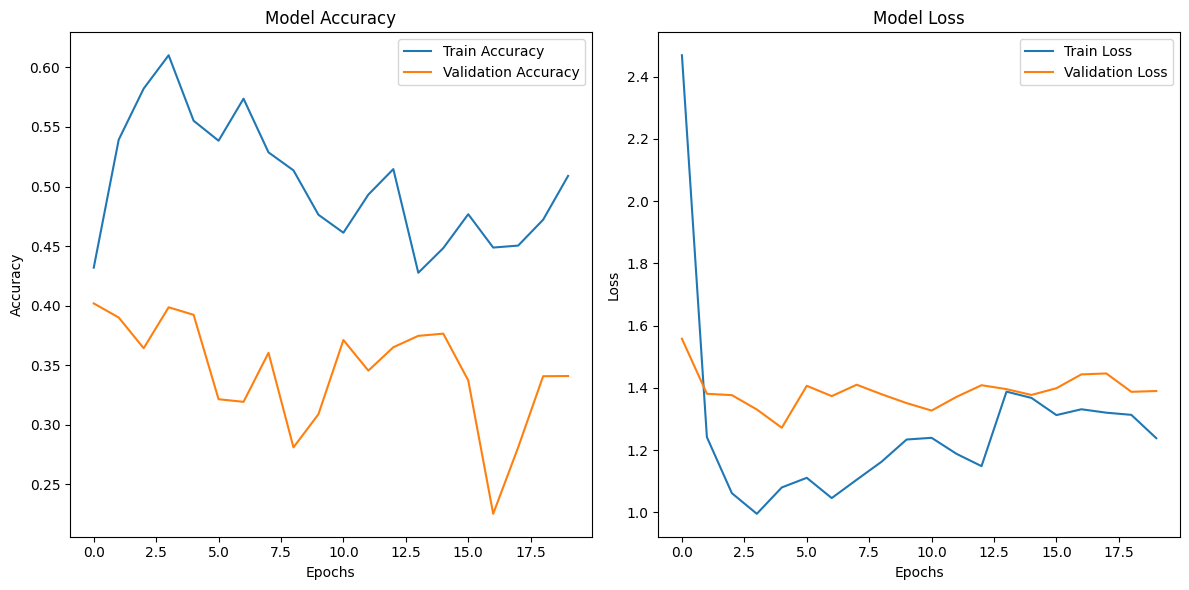

In [358]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [344]:
unique, counts = np.unique(y_resampled, return_counts=True)
result = dict(zip(unique, counts))

print(result)

{'C': 2359, 'L': 2359, 'R': 2359}


In [ ]:
y_pred = model.predict(X_test_scaled)[::-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


(31, 227, 3)

In [290]:
arr = y_pred[:,-1]

# Create a new array with the same shape as arr, filled with zeros
result = np.zeros_like(arr)

# Find the indices of the maximum values in each row
max_indices = np.argmax(arr, axis=1)

# Replace the maximum values with 1
rows = np.arange(arr.shape[0])  # Row indices
result[rows, max_indices] = 1

# Print the resulting array
result

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [292]:
y_test

array(['C', 'R', 'R', 'L', 'R', 'R', 'C', 'R', 'R', 'L', 'L', 'L', 'R',
       'L', 'L', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'C', 'R', 'L', 'R',
       'L', 'R', 'C', 'C', 'L'], dtype='<U8')

In [291]:
indices_y_pred = np.argmax(result, axis=1)
indices_y_test = np.argmax(y_test[:,-1], axis=1)

indices_y_pred, indices_y_test

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [311]:
unique, counts = np.unique(y_train, return_counts=True)
result = dict(zip(unique, counts))

print(result)

{'C': 771, 'L': 2359, 'R': 2281}


In [278]:
import numpy as np

# Example class counts
class_counts = np.array([5, 13, 13])  # Replace with actual class counts
total_samples = class_counts.sum()

# Compute class proportions
class_proportions = class_counts / total_samples

# Calculate average accuracy
average_accuracy = np.sum(class_proportions**2)

print(f"Class proportions: {class_proportions}")
print(f"Average accuracy of a random predictor: {average_accuracy:.4f}")


Class proportions: [0.16129032 0.41935484 0.41935484]
Average accuracy of a random predictor: 0.3777


In [285]:
import numpy as np
from sklearn.metrics import accuracy_score

# Step 1: Define class proportions and generate synthetic data
np.random.seed(29)  # For reproducibility

# Class counts (unbalanced classes)
class_counts = [5, 13, 13]  # Replace with actual counts
total_samples = sum(class_counts)
class_labels = [0, 1, 2]

# Generate true labels based on class proportions
true_labels = np.hstack([[label] * count for label, count in zip(class_labels, class_counts)])
np.random.shuffle(true_labels)

# Step 2: Generate random predictions based on class probabilities
class_proportions = np.array(class_counts) / total_samples

# Simulate random predictions
random_predictions = np.random.choice(
    class_labels, size=total_samples, p=class_proportions
)

# Step 3: Calculate accuracy
accuracy = accuracy_score(true_labels, random_predictions)
print(f"Empirical accuracy of the random predictor: {accuracy:.4f}")

# Step 4: Calculate theoretical average accuracy
theoretical_accuracy = np.sum(class_proportions**2)
print(f"Theoretical average accuracy: {theoretical_accuracy:.4f}")


Empirical accuracy of the random predictor: 0.2903
Theoretical average accuracy: 0.3777


In [276]:
np.product(counts/len(y_val))

0.02686243356386162

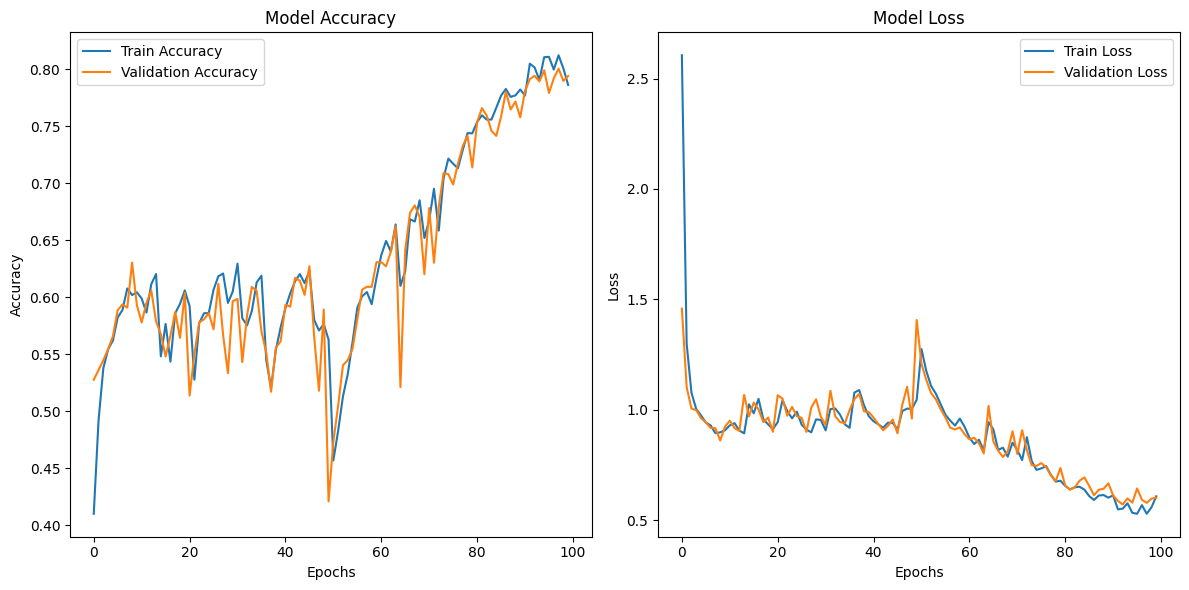

In [136]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
np.array([data[0]]).shape

(1, 219, 67)

In [140]:
label_encoder.transform(np.array([labels[0]]))

array([1])

In [299]:
y_pred = model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [301]:
y_pred.shape

(31, 227, 3)

In [156]:
y_pred[:,-1]

array([[0.21080802, 0.7191456 , 0.5950274 ],
       [0.01444075, 0.9919905 , 0.10848094],
       [0.8416812 , 0.28416497, 0.5215326 ],
       ...,
       [0.3071882 , 0.1873813 , 0.98200154],
       [0.05081065, 0.2561307 , 0.9977978 ],
       [0.96895623, 0.0820166 , 0.61298656]], dtype=float32)

In [168]:
y_test[:,-1]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [302]:
arr = y_pred[:,-1]

# Create a new array with the same shape as arr, filled with zeros
result = np.zeros_like(arr)

# Find the indices of the maximum values in each row
max_indices = np.argmax(arr, axis=1)

# Replace the maximum values with 1
rows = np.arange(arr.shape[0])  # Row indices
result[rows, max_indices] = 1

# Print the resulting array
print(result)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [304]:
indices_y_pred = np.argmax(result, axis=1)
indices_y_test = np.argmax(y_test_encoded, axis=1)

indices_y_pred.shape, indices_y_test.shape

((31,), (31,))

In [307]:
y_test

array(['C', 'R', 'R', 'L', 'R', 'R', 'C', 'R', 'R', 'L', 'L', 'L', 'R',
       'L', 'L', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'C', 'R', 'L', 'R',
       'L', 'R', 'C', 'C', 'L'], dtype='<U8')

In [308]:
y_test_encoded

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [306]:
12/31


0.3870967741935484

In [305]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(indices_y_test,indices_y_pred)

array([[0, 3, 2],
       [2, 6, 5],
       [0, 7, 6]], dtype=int64)

In [ ]:
misclassified_indices = np.where(~np.all(result == y_test[:,-1], axis=1))[0]

# Print misclassified examples
print("Misclassified indices:", len(misclassified_indices)/6002)
print("y_pred for misclassified samples:", y_pred[misclassified_indices])
print("y_test for misclassified samples:", y_test[misclassified_indices])

Misclassified indices: 0.10679773408863712
y_pred for misclassified samples: [[[0.32070208 0.60773194 0.6183162 ]
  [0.33183488 0.5948708  0.6165115 ]
  [0.34734902 0.57986206 0.61288637]
  ...
  [0.8420839  0.283627   0.52188706]
  [0.8418829  0.28389633 0.52170914]
  [1.         0.28416497 0.5215326 ]]

 [[0.3176614  0.60481244 0.62049055]
  [0.32009396 0.5891276  0.62767446]
  [0.3193242  0.5742134  0.64047456]
  ...
  [0.9266752  0.18500574 0.51314455]
  [0.9266918  0.18507648 0.5127518 ]
  [1.         0.18514608 0.5123615 ]]

 [[0.3135933  0.60994226 0.619167  ]
  [0.3094316  0.6032766  0.62120783]
  [0.3044201  0.5973509  0.6242488 ]
  ...
  [0.7672848  0.09902778 0.9110407 ]
  [0.76722765 0.09912506 0.9109116 ]
  [0.76716924 0.0992225  1.        ]]

 ...

 [[0.3191125  0.60548615 0.62043387]
  [0.31863788 0.5939966  0.6290493 ]
  [0.31148145 0.58631635 0.6422376 ]
  ...
  [0.19691382 0.91679865 0.11659962]
  [0.19659954 0.9171566  0.11609162]
  [0.19628605 1.         0.11559211]

In [208]:
testing_data = np.load('FullTestset.npy')
testing_labels = np.load("LabelsTestSet.npy")

In [210]:
testing_data.shape

(18, 227, 67)

In [211]:
testing_data_reshaped = testing_data.reshape(-1, landmarks)
testing_data_scaled = scaler.transform(testing_data_reshaped)
testing_data_scaled = testing_data_scaled.reshape(testing_data.shape)

In [ ]:
testing_data_scaled

(18, 227, 67)

In [215]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
label_encoder = LabelEncoder()
encoded_labels_testing = label_encoder.fit_transform(testing_labels)

y_encoded_testing = to_categorical(encoded_labels_testing, num_classes=3)
y_encoded_testing.shape

(18, 3)

In [216]:
y_encoded_repeated_repeated = np.repeat(y_encoded_testing[:, np.newaxis, :], 227, axis=1)  # Shape (samples, 219, 3)
y_encoded_repeated_repeated.shape

(18, 227, 3)

In [222]:
y_pred_testing = model.predict(testing_data_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [224]:
y_encoded_repeated_repeated[:,-1]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [225]:
arr = y_pred_testing[:,-1]

# Create a new array with the same shape as arr, filled with zeros
result = np.zeros_like(arr)

# Find the indices of the maximum values in each row
max_indices = np.argmax(arr, axis=1)

# Replace the maximum values with 1
rows = np.arange(arr.shape[0])  # Row indices
result[rows, max_indices] = 1

# Print the resulting array
print(result)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [230]:
indices_y_pred_test = np.argmax(result, axis=1)
indices_y_test_test = np.argmax(y_encoded_repeated_repeated[:,-1], axis=1)

indices_y_pred, indices_y_test

(array([1, 1, 0, ..., 2, 2, 0], dtype=int64),
 array([1, 1, 2, ..., 2, 2, 0], dtype=int64))

In [232]:
np.where(indices_y_pred_test!=indices_y_test_test)

(array([ 0,  1,  2,  3,  5,  6,  7, 10, 13, 14, 15, 16, 17], dtype=int64),)